In [1]:
!pip install fastdownload

In [2]:
!pip install --upgrade diffusers accelerate transformers

In [1]:
import os, sys
sys.path.append("..")

from src.vae import *

/home/user/conda/lib/python3.7/site-packages/librosa/core/constantq.py:1059: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.complex,


Dimension of this image: (512, 512, 3)


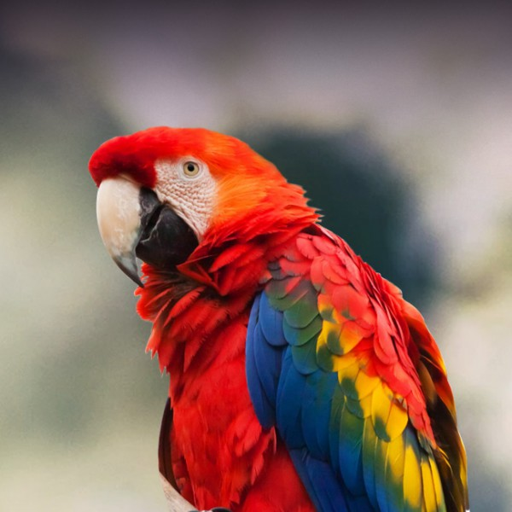

In [2]:
from fastdownload import FastDownload

p = FastDownload().download('https://lafeber.com/pet-birds/wp-content/uploads/2018/06/Scarlet-Macaw-2.jpg')
img = load_image(p)
print(f"Dimension of this image: {np.array(img).shape}")
img

In [3]:
latent_img = pil_to_latents(img)
print(f"Dimension of this latent representation: {latent_img.shape}")

Dimension of this latent representation: torch.Size([1, 4, 64, 64])


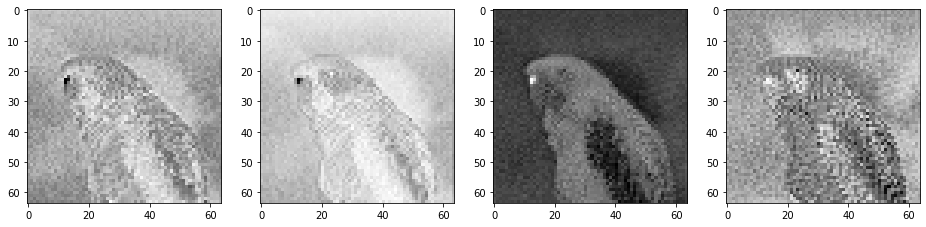

In [4]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for c in range(4):
    axs[c].imshow(latent_img[0][c].detach().cpu(), cmap='Greys')

In [54]:
images = []

for i in range(4):
    for j in range(4):
        for y in range(4):
            if i == y or i == j or j == y:
                continue
            
            images.append(torch.dstack((latent_img[0][i].detach().cpu(),latent_img[0][j].detach().cpu(),latent_img[0][y].detach().cpu())))

In [59]:
images[0].shape

torch.Size([64, 64, 3])

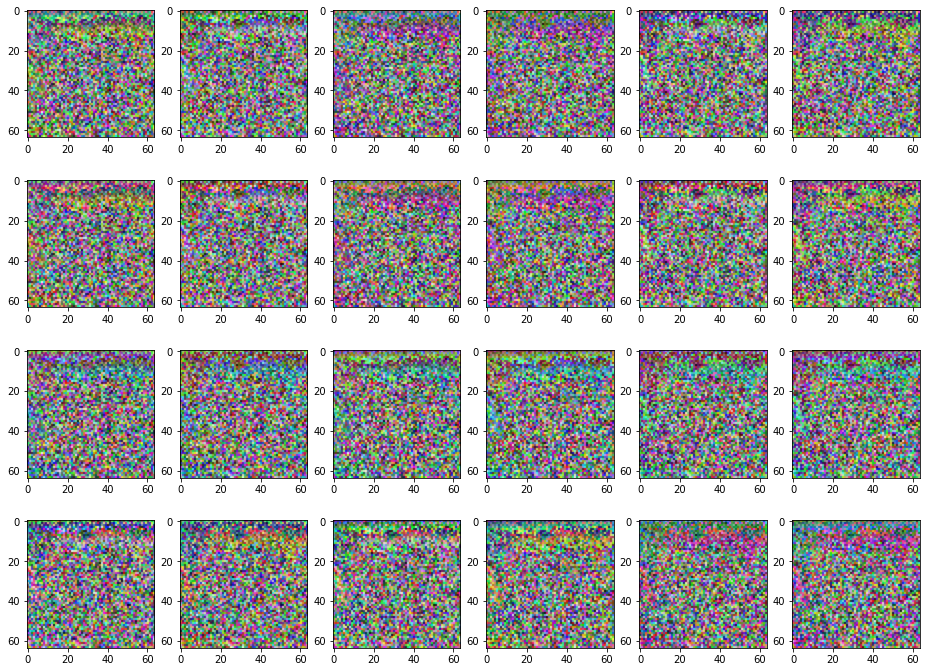

In [66]:
fig, axs = plt.subplots(4, 6, figsize=(16, 12))
for b in range(4): 
    for c in range(6):
        axs[b][c].imshow(transform(images[6*b + c].permute(2,0,1)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

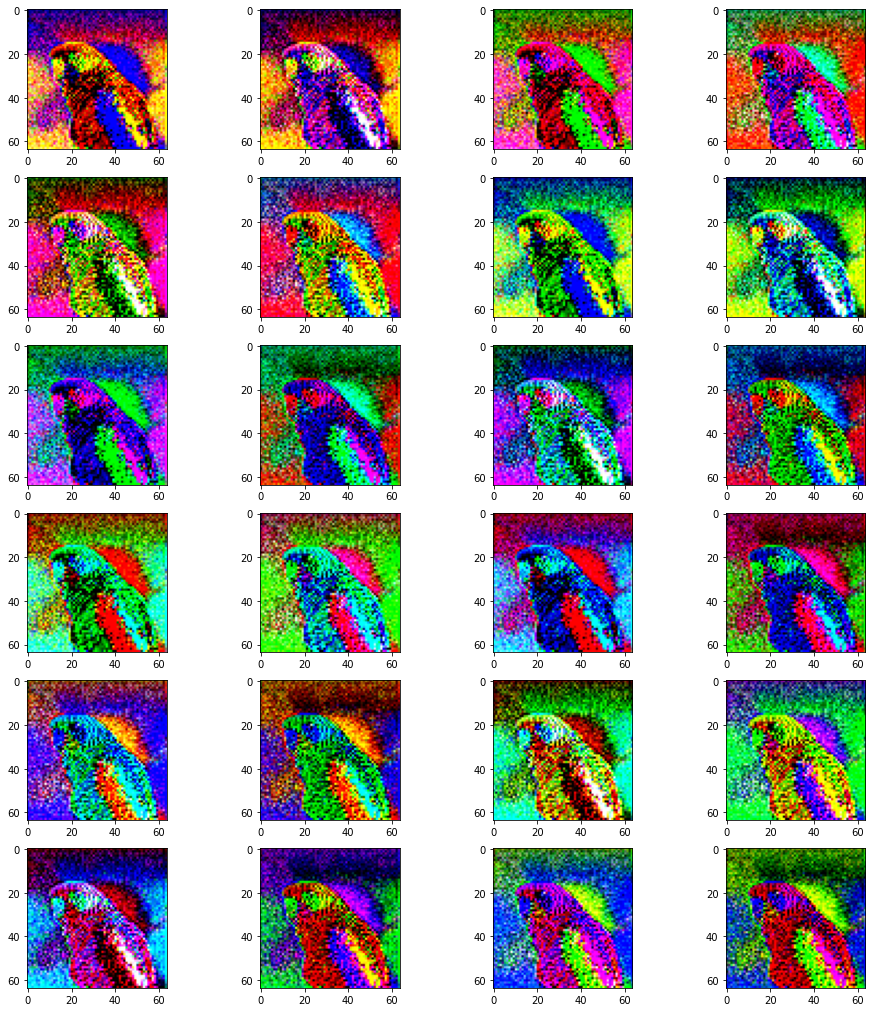

In [69]:
from itertools import permutations
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 20]
fig, axs = plt.subplots(6, 4, figsize=(16, 18))

i = 0
for ch1, ch2, ch3 in permutations('0123', 3):
    ch1, ch2, ch3 = map(int, [ch1, ch2, ch3])
    axs[i//4, i%4].imshow(
        latent_img[0][[ch1, ch2, ch3], :].detach().float().permute(1, 2, 0).cpu()
    )
    i+=1

In [ ]:
glob('/home/jovyan/checkpoints/mse/celeba_male_celeba_female_512/*')

In [36]:
img = transform(latent_img[0][0:3].detach().cpu())

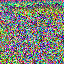

In [37]:
img

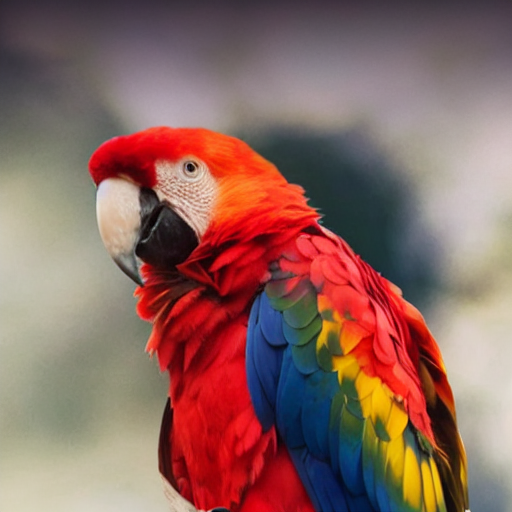

In [12]:
decoded_img = latents_to_pil(latent_img.to('cuda'))
decoded_img

In [5]:
model_parameters = filter(lambda p: p.requires_grad, vae.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

83653863

In [2]:
from torch.utils.data import Dataset, DataLoader
from glob import glob

class Dataset_for_latent(Dataset):
    def __init__(self, path):
        self.path = path
        
        self.filename = glob(self.path + '/*.jpg')
        
    def __len__(self):
        return len(self.filename)
    
    def __getitem__(self, idx):
        file = self.filename[idx]
        name = file.split('/')[-1].split('.')[0]
        
        image = load_image(file)
        latent_img = pil_to_latents(image)
        
        return latent_img, name

In [3]:
! ls ../..

NOT_in_latent_space  checkpoints2	 checkpoints_tensor  quick-start
bolgov		     checkpoints3	 data		     shares
checkpoints1	     checkpoints_latent  portraits_64k.zip


In [4]:
dataset_male = Dataset_for_latent('/home/jovyan/data/dataset/male')
dataset_anime = Dataset_for_latent('../../data/anime/portraits_64k')

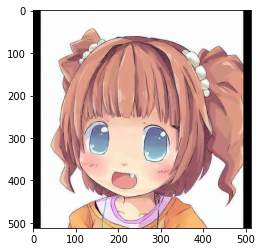

In [33]:
for i in range(50, 60):
    decoded_img = np.array(latents_to_pil(dataset_anime[i][0])[0])
    plt.imshow(decoded_img)
    black = np.mean(decoded_img.astype(bool)) < 0.8
    if black:
        plt.show()

In [48]:
len(dataset_anime)

64483

In [5]:
loader_male = DataLoader(dataset_male, batch_size=1)
loader_anime = DataLoader(dataset_anime, batch_size=1)

In [35]:
print(os.path.join('/home/jovyan/data/CelebA_HQ_lanent/male', "file.txt"))

/home/jovyan/data/CelebA_HQ_lanent/male/file.txt


In [17]:
male = []
anime = []

In [18]:
import torch
import time
from tqdm import tqdm 

i = 0
for latent, file in tqdm(loader_anime):
    black = latent[0].float().mean().item() < -0.1
    if black:
        continue
        
    i+=1
    if i % 1000 == 0:
        time.sleep(10)
        
    anime.append(latent[0].to(device="cpu", dtype=torch.float16))

100%|██████████| 64483/64483 [1:30:12<00:00, 11.91it/s]  


In [ ]:
for latent, file in tqdm(loader_female):
    female.append(latent[0].to(device="cpu", dtype=torch.float16) )

 39%|███▉      | 16883/42905 [17:04<17:26, 24.86it/s]  

In [19]:
anime = torch.vstack(anime)
anime.shape

torch.Size([58997, 4, 64, 64])

In [27]:
female = torch.vstack(female)

In [20]:
torch.save(anime, '/home/jovyan/data/dataset/anime.pt')

In [30]:
torch.save(female, '/home/jovyan/data/dataset/woman.pt')

In [18]:
import torch

for latent, file in loader_male:
    if not(os.path.isdir('/home/jovyan/data/CelebA_HQ_lanent/male')):
        os.mkdir('/home/jovyan/data/CelebA_HQ_lanent/male')
    torch.save(latent, '/home/jovyan/data/CelebA_HQ_lanent/male' + f"/{file[0]}.pt")

In [19]:
for latent, file in loader_female:
    if not(os.path.isdir('/home/jovyan/data/CelebA_HQ_lanent/female')):
        os.mkdir('/home/jovyan/data/CelebA_HQ_lanent/female')
    torch.save(latent, '/home/jovyan/data/CelebA_HQ_lanent/female' + f"/{file[0]}.pt")

In [33]:
! mkdir ../../data/anime